
# Explanation of the task:

This is the classic Emotion Recognition Classification task. Given a conversation, involving 2 or more parties, for each message/utterance, we want to predict an emotion related to it.


Consider the example:

**Person A**: "Hello! I am very happy" (happiness)

**Person B**: "Why? I am very angry"   (anger)

## First model idea:
- inputs: sequence of utterances, sequence of emotions.
- For each: Linear Layers
- Fusion model

- Loss: cross-entropy



# Other approach:

Consider the each conversation as just a sequence of words:
$$
[[utt, utt, \cdots], \cdots ] \longrightarrow [[word, word , \cdots], \cdots]
$$

Issue comes when there is some separator: How to implement it? Idea: Use a random token to represent it.

## Weight update:
 - Make the updatable weights constant and then update it dynamically
 - train it once and them update it dynamically in the forward pass
 - cache weight matrices and train them individually -> this does not train properly (super slow convergence)


In [52]:
! pip install nltk
! pip install torch
! pip install pandas
! pip install gensim
! pip install datasets
! pip install matplotlib
! pip install tqdm
! pip install torchinfo

# eventually include tensorboard

In [53]:
# ML resources:
import torch
import os
import matplotlib.pyplot as plt
import gensim
from nltk.tokenize import TweetTokenizer

from datasets import load_dataset
from torch.utils.data import Dataset, DataLoader
from collections import Counter

#others:
import pandas as pd
import numpy as np



In [54]:
! wget https://dl.fbaipublicfiles.com/fasttext/vectors-english/wiki-news-300d-1M.vec.zip
! unzip wiki-news-300d-1M.vec.zip
! rm wiki-news-300d-1M.vec.zip

--2025-01-16 13:26:27--  https://dl.fbaipublicfiles.com/fasttext/vectors-english/wiki-news-300d-1M.vec.zip
Resolving dl.fbaipublicfiles.com (dl.fbaipublicfiles.com)... 18.238.176.19, 18.238.176.115, 18.238.176.126, ...
Connecting to dl.fbaipublicfiles.com (dl.fbaipublicfiles.com)|18.238.176.19|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 681808098 (650M) [application/zip]
Saving to: ‘wiki-news-300d-1M.vec.zip’

wiki-news-300d-1M.v 100%[===================>] 650.22M  89.7MB/s    in 7.5s    

2025-01-16 13:26:35 (87.0 MB/s) - ‘wiki-news-300d-1M.vec.zip’ saved [681808098/681808098]

Archive:  wiki-news-300d-1M.vec.zip
replace wiki-news-300d-1M.vec? [y]es, [n]o, [A]ll, [N]one, [r]ename: n


In [55]:
encoder_model = gensim.models.KeyedVectors.load_word2vec_format("wiki-news-300d-1M.vec",binary = False)

In [56]:
# We create the embedding matrix and find the vocab
import copy
unk_token, pad_token, sep_token = '<unk>', '<pad>','<sep>'
embedding_vectors = torch.from_numpy(encoder_model.vectors)
pretrained_vocab = copy.deepcopy(encoder_model.index_to_key)
pretrained_vocab[:0] = [unk_token, pad_token,sep_token]

stoi = {word: i for i, word in enumerate(pretrained_vocab)}
itos = {i: word for i, word in enumerate(pretrained_vocab)}

pretrained_embeddings = torch.cat((torch.ones(1,embedding_vectors.shape[1]),embedding_vectors))
pretrained_embeddings = torch.cat((torch.zeros(1,embedding_vectors.shape[1]),embedding_vectors))
pretrained_embeddings = torch.cat((-torch.ones(1,embedding_vectors.shape[1]),embedding_vectors))

In [57]:
from nltk.tokenize import TweetTokenizer

## By using the template that was shared, we can process the inputs in a very similar way
tok = TweetTokenizer()
def tokenize_text_extend_emotions(text,emotion,stoi):
  t1 = tok.tokenize(text)
  text_tokenized = [stoi[word] if word in stoi else stoi['<unk>'] for word in t1]
  return text_tokenized, [emotion]*len(t1)


def concat_utt(dialog,emotions,stoi): ## This is the tweek explained in the beggining of the file
  tokenized_and_extended = [tokenize_text_extend_emotions(t,e,stoi) for t,e in zip(dialog,emotions)]
  dialog1 = [i[0] for i in tokenized_and_extended]
  emotions1 = [i[1] for i in tokenized_and_extended]
  dialog_flat = []
  emotions_extended = []
  for i in range(len(dialog1) - 1):
    dialog1[i].append(stoi["<sep>"])
    emotions1[i].append(emotions1[i][0])
  for i in range(len(dialog1)):
    dialog_flat.extend(dialog1[i])
    emotions_extended.extend(emotions1[i])
  return dialog_flat,emotions_extended

## Check the following example:

dialog_example = ["hello, I am a I robot!","I am greek"]
emotions_example = [1,2] ## random emotions...
flatten_dialog, flatten_emotions = concat_utt(dialog_example,emotions_example,stoi)
print(f"{dialog_example} became {flatten_dialog}")
print(f"{emotions_example} became {flatten_emotions}")

['hello, I am a I robot!', 'I am greek'] became [13172, 3, 31, 784, 10, 31, 6872, 80, 2, 31, 784, 22505]
[1, 2] became [1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 2]


## DataLoader not implemented yet:

In [58]:
## Modify this after changing the preprocessing.
class DailyDialogDataset(Dataset):
  def __init__(self, texts, emotions,target_texts,target_emotions):
  # Dataset object for Daily Dialog dataset
    self.texts = texts                       ## text with embeddings
    self.emotions = emotions                 ## emotion with embeddings
    self.target_texts = target_texts         ## text for CrossEntropy
    self.target_emotions = target_emotions   ## emotions for CrossEntropy

  def __len__(self):
    return len(self.texts)

  def __getitem__(self, idx):
    item = {
        'texts': self.texts[idx],
        'emotions': self.emots[idx],
        'target_texts': self.target_text[idx],
        'target_emotions': self.target_emotion[idx]
    }
    return item



Here we will extract the data:

In [62]:
emotions_emb = {}

data = load_dataset('daily_dialog')

X_train = data['train']['dialog']
Y_train = data['train']['emotion']

X_test = data['test']['dialog']
Y_test = data['test']['emotion']

X_val = data['validation']['dialog']
Y_val = data['validation']['emotion']


In [63]:
from tqdm.notebook import tqdm

def preprocess_data(X,Y):
  X_processed = []
  Y_processed = []
  for i in tqdm(range(len(X))):
    X_processed.append(concat_utt(X[i],Y[i],stoi)[0])
    Y_processed.append(concat_utt(X[i],Y[i],stoi)[1])
  return X_processed, Y_processed

X_train, Y_train = preprocess_data(X_train,Y_train)
X_test, Y_test = preprocess_data(X_test,Y_test)
X_val, Y_val = preprocess_data(X_val,Y_val)


for d,e in zip(X_train,Y_train): ## Just checking if nothing wrong happened
  assert(len(d) == len(e))
for d,e in zip(X_test,Y_test): ## Just checking if nothing wrong happened
  assert(len(d) == len(e))
for d,e in zip(X_val,Y_val): ## Just checking if nothing wrong happened
  assert(len(d) == len(e))

  0%|          | 0/11118 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

In [67]:
print(Y_train[0])
# batch_size = 800
# train_data = DailyDialogDataset(X_train1[:-1],Y_train1[:-1],X_train_utt[1:],Y_train_emo[1:])
# test_data = DailyDialogDataset(X_test1[:-1],Y_test1[:-1],X_test_utt[1:],Y_test_emo[1:])
# val_data = DailyDialogDataset(X_val1[:-1],Y_val1[:-1],X_val_utt[1:],Y_val_emo[1:])

# train_loader = DataLoader(train_data, batch_size=batch_size,shuffle = True)
# test_loader = DataLoader(test_data, batch_size=batch_size,shuffle = True)
# val_loader = DataLoader(val_data, batch_size=batch_size, shuffle = True)


[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4]


# The model:
## archtecture
- 2 input channels: word encoding, emotion encoding
- dinamically updated weights: $w_1, w_2 = w1 + w2, w1$ (Not implemented yet)
### For each channel:
   - 3 sequential Linear layers
- fusion linear layer through concatenation
- 2 output channels which contain a linear layer each





In [ ]:
import torch.nn as nn
import torch.nn.functional as F
class SimpleModel(nn.Module):
  def __init__(self, word_dim, emo_dim, emotions_size, vocab_size):
    super(SimpleModel,self).__init__()
    ## Decide size later!
    self.embedding_layer = nn.Embedding.from_pretrained(pretrained_embeddings,freeze=True)
    self.decoder = nn.Linear(emo_dim,vocab_size)
    ## Channel for utterances/words:
    self.Linear_utt1 = nn.Linear(word_dim,80)
    self.Linear_utt2 = nn.Linear(80,80)
    self.Linear_utt3 = nn.Linear(80,80)
    self.Linear_utt3.requires_grad = False

    ## Channel for emotions:
    self.Linear_emo1 = nn.Linear(emo_dim,80)
    self.Linear_emo2 = nn.Linear(80,80)
    self.Linear_emo3 = nn.Linear(80,80)
    self.Linear_emo3.requires_grad = False

    ## fusion by concatenation and Linear layer:
    self.Linear_fus = nn.Linear(160,300)

    ## We concatenate and do linear again (2 different concatenations)
    self.Linear_utt_final = nn.Linear(380, word_dim)
    self.Linear_emo_final = nn.Linear(380, emotions_size)

    self.softmax = nn.Softmax(dim=0)



  def forward(self, text_emb, emo_emb):

    x = self.Linear_utt1(text_emb)
    x = self.Linear_utt2(x)
    x = self.Linear_utt3(x)

    y = self.Linear_emo1(emo_emb)
    y = self.Linear_emo2(y)
    y = self.Linear_emo3(y)

    z = torch.cat((x,y),-1) ## very simple
    z = self.Linear_fus(z)

    w = torch.cat((z,x),-1)

    pred_token = self.Linear_utt_final(w)
    pred_token = self.decoder(pred_token)
    pred_token = self.softmax(pred_token)

    v = torch.cat((z,y),-1)
    v = self.Linear_emo_final(v)

    pred_emotion = self.softmax(v)
    return pred_token, pred_emotion



In [ ]:
import torch.optim as optim
from tqdm.notebook import tqdm
def activate_gpu(force_cpu=False): # check if gpu available ; code taken from template
    device = "cpu"
    if not force_cpu:
        if torch.cuda.is_available(): # for both Nvidia and AMD GPUs
            device = 'cuda'
            print('DEVICE = ', torch.cuda.get_device_name(0))
        elif torch.backends.mps.is_available(): # for mac ARM chipset
            device = 'mps'
            print('DEVICE = ', "mps" )
        else: # for cpu only
            device = 'cpu'
            print('DEVICE = ', 'CPU', "blue")
    return device

## normal train function
def train(model, epochs, device):
  optimizer = optim.Adam(model.parameters())
  loss_fn = nn.CrossEntropyLoss()
  model.train()
  model = model.to(device)
  loss1 = 0
  loss2 = 0
  loss = 0
  loss_to_plot = []
  for epoch in range(epochs):
    losses = []
    print(f"Epoch {epoch+1}/{epochs}")
    for it, batch in tqdm(enumerate(train_loader),total = train_loader.__len__()):
      batch = {'text': batch['text'].to(device), 'emot': batch['emot'].to(device), 'text_class': batch['text_class'].to(device), 'emot_class': batch['emot_class'].to(device)}
      optimizer.zero_grad()
      pt, pe  = model.forward(batch['text'],batch['emot'])
      loss1 = loss_fn(pe, batch['emot_class'])
      loss2 = loss_fn(pt, batch['text_class'])
      loss = loss1 + loss2
      loss.backward()
      optimizer.step()
      losses.append(loss.item())
    loss_to_append = sum(losses)/len(losses)
    loss_to_plot.append(loss_to_append)
    print(f"loss: ",loss_to_append)
  return loss_to_plot


In [ ]:
device = activate_gpu()
fn = nn.CrossEntropyLoss()
model = SimpleModel(word_dim,word_dim,len(emotions),len(train_X_class))
print(device)

DEVICE =  Tesla T4
cuda


Epoch 1/7


  0%|          | 0/1251 [00:00<?, ?it/s]

loss:  1.940275966787605
Epoch 2/7


  0%|          | 0/1251 [00:00<?, ?it/s]

loss:  1.9422408693985973
Epoch 3/7


  0%|          | 0/1251 [00:00<?, ?it/s]

loss:  1.9422070345432638
Epoch 4/7


  0%|          | 0/1251 [00:00<?, ?it/s]

loss:  1.9433306957796799
Epoch 5/7


  0%|          | 0/1251 [00:00<?, ?it/s]

loss:  1.9439430320672662
Epoch 6/7


  0%|          | 0/1251 [00:00<?, ?it/s]

loss:  1.9447306879609227
Epoch 7/7


  0%|          | 0/1251 [00:00<?, ?it/s]

loss:  1.9447204503509925


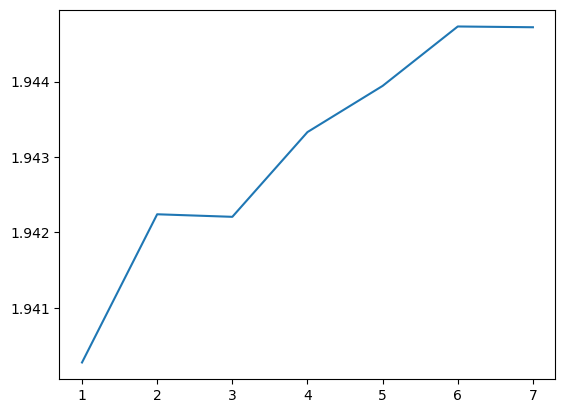

In [ ]:
epochs = 7

losses = train(model,epochs,device)
plt.plot(np.arange(1,epochs+1),losses)

# Descrition of the issues faced:

It is not trivial of how to deal with the gradient flow in this case. Maybe by fixing the 2 matrix it would go better. Or just train the matrix with fixed weight. And update the weight not in the forward pass. but in the prediction. this way we can cache the weight and everytime we restart, we will be ok.

I believe that, the issue of this approach specifically is updating directly the weights, and not, a hidden state, for instance.

# Problem with Daily Dialog:
By plotting the frequency of each emotion, we notice that the dataset is truly not diversified. It has essentially only 2 emotions. This is not ideal, because the models will most likely overfit into predicting those 2 emotions...

In [ ]:
def compute_test_loss(model,loss_fn,data_loader,device):
  model.eval()
  losses = []
  accs = []
  preds = []
  prec = 0
  trues = []
  pred_words = []
  for it,batch in tqdm(enumerate(data_loader),total=data_loader.__len__()):
    batch = {'text' : batch['text'].to(device),'emot': batch['emot'].to(device),'text_class': batch['text_class'].to(device),'emot_class': batch['emot_class'].to(device)}
    pt, pe  = model.forward(batch['text'],batch['emot'])
    loss = loss_fn(pe,batch['emot_class'])
    index_pred = torch.argmax(pe,1)
    word_p = torch.argmax(pt,1)
    correct = (batch['emot_class'].flatten() == index_pred.flatten()).float().sum()
    acc = correct/len(index_pred.flatten())
    accs.append(acc.item())
    losses.append(loss.item())
    trues.extend(batch['emot_class'].flatten().tolist())
    preds.extend(index_pred.tolist())
    pred_words.extend(word_p.tolist())
    for i in batch['text_class']:
      i.item()
  print("average loss: ", sum(losses)/len(losses))
  print("average acc: ", sum(accs)/len(accs))
  return trues, preds, word_p
trues, preds, pred_words = compute_test_loss(model,nn.CrossEntropyLoss(),val_loader,device)
names = [f'{i}' for i in range(1,8)]



  0%|          | 0/115 [00:00<?, ?it/s]

average loss:  1.9445405493611876
average acc:  0.6574382173707304


In [ ]:
#for i,w,q in zip(trues[:50],preds[:50],pred_words[:50]):
#  print(i,w,itos_train1[q.item()])
#
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc, RocCurveDisplay
print(classification_report(np.array(trues).flatten(), np.array(preds).flatten(), target_names=names))
confusion_matrix(trues,preds)

              precision    recall  f1-score   support

           1       0.96      0.72      0.82     82011
           2       0.00      0.00      0.00      1083
           3       0.00      0.00      0.00        41
           4       0.16      0.17      0.16       126
           5       0.01      0.02      0.01      6231
           6       0.93      0.93      0.93      1085
           7       0.81      0.27      0.40      1033

    accuracy                           0.66     91610
   macro avg       0.41      0.30      0.33     91610
weighted avg       0.88      0.66      0.75     91610



array([[59060,  9073,   402,     7, 13373,    68,    28],
       [ 1064,     1,     5,     1,    10,     2,     0],
       [   28,     0,     0,     0,     1,     0,    12],
       [    7,    54,     0,    21,    24,     0,    20],
       [  509,    20,  5588,     2,   106,     4,     2],
       [   49,     4,     5,     1,    16,  1008,     2],
       [  621,     4,    11,   100,    19,     3,   275]])

In [ ]:
def eval_sentence(model, sentence, encoded_sentence, emotions, device):
  model.eval()
  for i in range(len(sentence) - 1):
    pe, _ = model.forward(encoded_sentence[i].to(device),emotions[i].to(device))
    t = torch.max(pe,1)
    print(f"word:{sentence[i+1]}; predicted_emotion: {t} ; target_emotion: {emotions[i+1]}")

# eval_sentence(model,sentence,encod,emot,device)